In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import gdown

url = 'https://drive.google.com/a/itu.edu.pk/uc?id=1-HQQciKYfwAO3oH7ci6zhg45DduvkpnK&export=download'

gdown.download(url,'/content/drive/My Drive/Assignment 05.zip', quiet=False)

Downloading...
From: https://drive.google.com/a/itu.edu.pk/uc?id=1-HQQciKYfwAO3oH7ci6zhg45DduvkpnK&export=download
To: /content/drive/My Drive/Assignment 05.zip
5.96GB [01:19, 74.5MB/s]


'/content/drive/My Drive/Assignment 05.zip'

In [0]:
# !unzip -q '/content/drive/My Drive/Assignment 05.zip'
!unzip  '/content/drive/My Drive/Assignment 05.zip' -d  '/content/drive/My Drive'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/My Drive/Assignment 5 Dataset/train/normal/7ec0b033-9133-4f8c-abd0-ea246aa21dfa.png  
  inflating: /content/drive/My Drive/Assignment 5 Dataset/train/normal/7ec4666c-0304-4b7b-8263-bf417ab7cccd.png  
  inflating: /content/drive/My Drive/Assignment 5 Dataset/train/normal/7ee9ace4-3059-49c4-9356-705203289e46.png  
  inflating: /content/drive/My Drive/Assignment 5 Dataset/train/normal/7ef283b8-9c5a-4ada-a575-f68289e338ae.png  
  inflating: /content/drive/My Drive/Assignment 5 Dataset/train/normal/7ef98cac-f239-406e-af10-67aead1e038f.png  
  inflating: /content/drive/My Drive/Assignment 5 Dataset/train/normal/7efb172c-23b7-4d57-bd57-bd461b9e7ca7.png  
  inflating: /content/drive/My Drive/Assignment 5 Dataset/train/normal/7f015127-0907-4ba7-8021-cf868a210d4c.png  
  inflating: /content/drive/My Drive/Assignment 5 Dataset/train/normal/7f05b70f-2ad0-4db6-9e05-6c2baec8cd52.png  
  inflating: /content/drive/My Drive/

In [0]:
data_dir = '/content/drive/My Drive/Assignment 5 Dataset'

In [28]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/validation', transform=valid_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


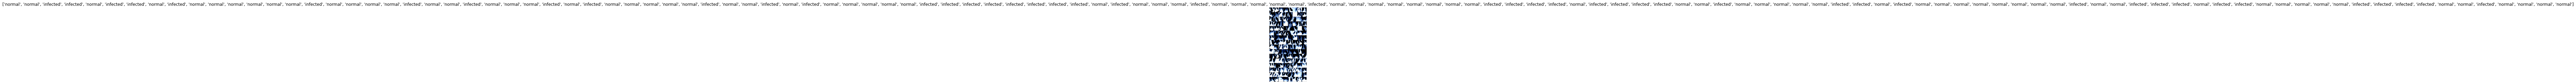

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


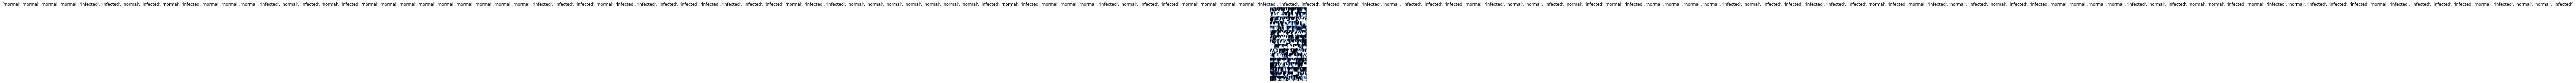

In [5]:
 def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [6]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=False)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
fl_neu_inp = vgg16.classifier[0].in_features
features = list(vgg16.classifier)[:-7]
features

[]

In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [0]:
features.extend(
    [
     nn.Linear(fl_neu_inp,1050),
     nn.ReLU(inplace=True),
     nn.Dropout(inplace=False),
     nn.Linear(1050, len(class_names))])

In [10]:
features

[Linear(in_features=25088, out_features=1050, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=1050, out_features=2, bias=True)]

In [11]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [13]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
        
    torch.save(vgg16.state_dict(), 'vgg16_ft.pth')

print('Finished Training')

Train Epoch: 0 [8928/12000 (99%)]	Loss: 0.651336: : 94it [1:20:24, 51.32s/it]
Train Epoch: 1 [8928/12000 (99%)]	Loss: 0.633701: : 94it [04:46,  3.05s/it]
Train Epoch: 2 [8928/12000 (99%)]	Loss: 0.576118: : 94it [04:45,  3.03s/it]
Train Epoch: 3 [8928/12000 (99%)]	Loss: 0.555390: : 94it [04:39,  2.97s/it]
Train Epoch: 4 [8928/12000 (99%)]	Loss: 0.640343: : 94it [04:43,  3.02s/it]
Train Epoch: 5 [8928/12000 (99%)]	Loss: 0.598555: : 94it [04:42,  3.00s/it]
Train Epoch: 6 [8928/12000 (99%)]	Loss: 0.529859: : 94it [04:42,  3.01s/it]
Train Epoch: 7 [8928/12000 (99%)]	Loss: 0.573186: : 94it [04:41,  3.00s/it]
Train Epoch: 8 [8928/12000 (99%)]	Loss: 0.558441: : 94it [04:43,  3.01s/it]
Train Epoch: 9 [8928/12000 (99%)]	Loss: 0.593916: : 94it [04:45,  3.04s/it]

Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


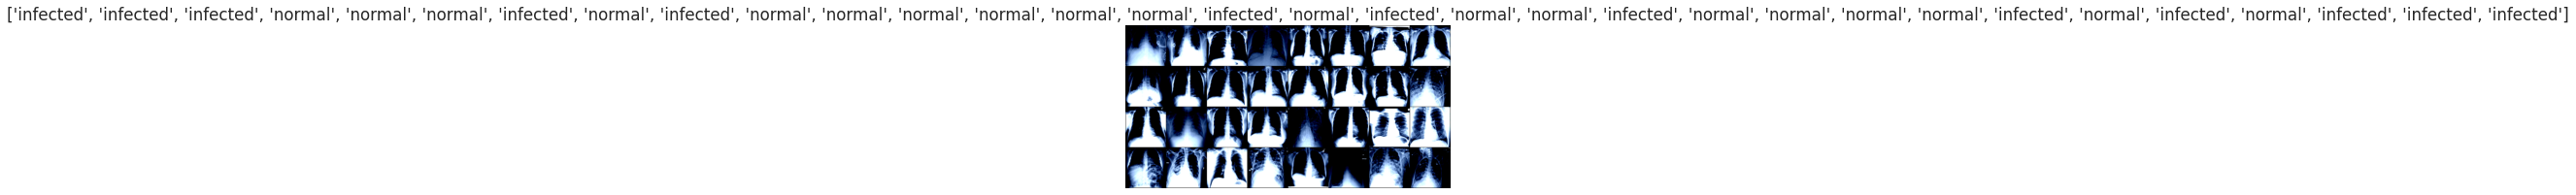

In [34]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [35]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected normal normal normal normal normal normal normal normal normal normal normal normal normal normal infected normal infected normal normal infected normal normal normal normal infected normal infected normal normal infected infected
Ground Truth:  infected infected infected normal normal normal infected normal infected normal normal normal normal normal normal infected normal infected normal normal infected normal normal normal normal infected normal infected normal infected infected infected


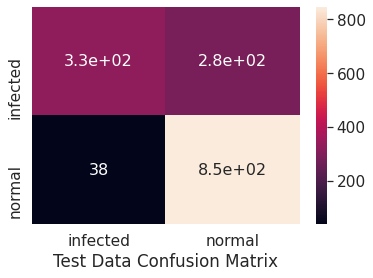

Accuracy of the network on Test Data: 78 %


In [36]:
correct = 0
total = 0
confusionMatrix = np.zeros((2, 2));
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        confusionMatrix += confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

acc = 100 * correct / total

df_cm = pd.DataFrame(confusionMatrix, class_names, class_names)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.xlabel("Test Data Confusion Matrix")
plt.show()

print('Accuracy of the network on Test Data: %d %%' % (acc))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


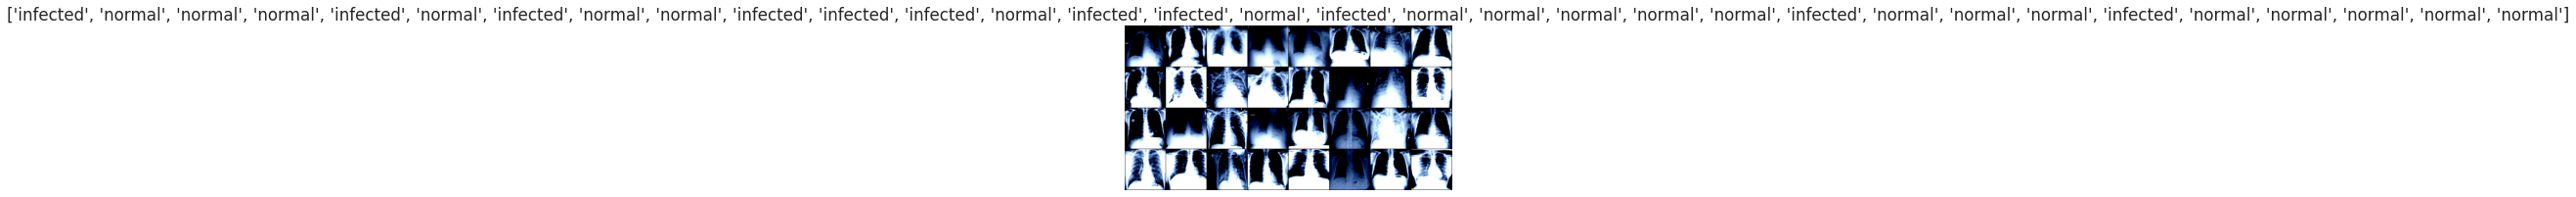

In [31]:
dataiter = iter(validloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [32]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal normal normal normal normal infected normal normal normal infected infected normal infected infected normal normal normal normal infected normal normal infected normal normal normal infected normal normal normal normal normal
Ground Truth:  infected normal normal normal infected normal infected normal normal infected infected infected normal infected infected normal infected normal normal normal normal normal infected normal normal normal infected normal normal normal normal normal


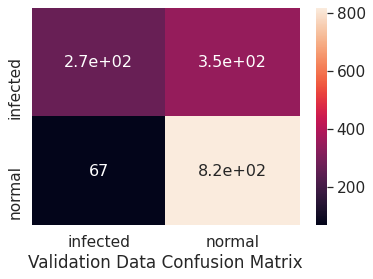

Accuracy of the network on vlidation Data: 72 %


In [58]:
correct = 0
total = 0
confusionMatrix = np.zeros((2, 2));
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        confusionMatrix += confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

acc = 100 * correct / total

df_cm = pd.DataFrame(confusionMatrix, class_names, class_names)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.xlabel("Validation Data Confusion Matrix")
plt.show()

print('Accuracy of the network on vlidation Data: %d %%' % (acc))

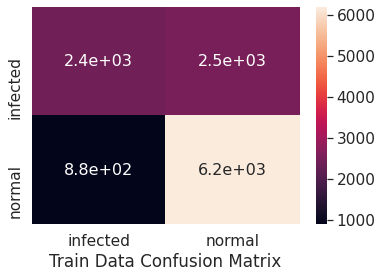

Accuracy of the network on Train Data: 71 %


In [59]:
correct = 0
total = 0
confusionMatrix = np.zeros((2, 2));
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        confusionMatrix += confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

acc = 100 * correct / total

df_cm = pd.DataFrame(confusionMatrix, class_names, class_names)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.xlabel("Train Data Confusion Matrix")
plt.show()

print('Accuracy of the network on Train Data: %d %%' % (acc))

In [37]:
resnet = models.resnet18(pretrained=True)
print(resnet)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [0]:
resnet.fc = nn.Sequential(
  nn.Linear(resnet.fc.in_features, 1050, bias=True),
  nn.ReLU(inplace=True),
  nn.Dropout(p=0.5, inplace=False),
  nn.Linear(1050, len(class_names), bias=True)
)

In [40]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Freeze training for all layers
for param in resnet.parameters():
    param.requires_grad = False 

for param in resnet.fc.parameters():
    param.requires_grad = True

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)


0it [00:00, ?it/s]
Train Epoch: 0 [0/12000 (0%)]	Loss: 0.713513: : 0it [00:10, ?it/s]
Train Epoch: 0 [0/12000 (0%)]	Loss: 0.713513: : 1it [00:10, 10.66s/it]
Train Epoch: 0 [128/12000 (1%)]	Loss: 0.678023: : 1it [00:20, 10.66s/it]
Train Epoch: 0 [128/12000 (1%)]	Loss: 0.678023: : 2it [00:20, 10.37s/it]
Train Epoch: 0 [256/12000 (2%)]	Loss: 0.689922: : 2it [00:26, 10.37s/it]
Train Epoch: 0 [256/12000 (2%)]	Loss: 0.689922: : 3it [00:26,  9.22s/it]
Train Epoch: 0 [384/12000 (3%)]	Loss: 0.683062: : 3it [00:34,  9.22s/it]
Train Epoch: 0 [384/12000 (3%)]	Loss: 0.683062: : 4it [00:34,  8.78s/it]
Train Epoch: 0 [512/12000 (4%)]	Loss: 0.647569: : 4it [00:45,  8.78s/it]
Train Epoch: 0 [512/12000 (4%)]	Loss: 0.647569: : 5it [00:45,  9.41s/it]
Train Epoch: 0 [640/12000 (5%)]	Loss: 0.656818: : 5it [00:55,  9.41s/it]
Train Epoch: 0 [640/12000 (5%)]	Loss: 0.656818: : 6it [00:55,  9.61s/it]
Train Epoch: 0 [768/12000 (6%)]	Loss: 0.740058: : 6it [01:04,  9.61s/it]
Train Epoch: 0 [768/12000 (6%)]	Loss: 0

Training Accuracy of Epoch 0: 74 %



0it [00:00, ?it/s]

Validation Accuracy of Epoch 0: 79 %



Train Epoch: 1 [0/12000 (0%)]	Loss: 0.462209: : 0it [00:02, ?it/s]
Train Epoch: 1 [0/12000 (0%)]	Loss: 0.462209: : 1it [00:02,  2.74s/it]
Train Epoch: 1 [128/12000 (1%)]	Loss: 0.404978: : 1it [00:05,  2.74s/it]
Train Epoch: 1 [128/12000 (1%)]	Loss: 0.404978: : 2it [00:05,  2.73s/it]
Train Epoch: 1 [256/12000 (2%)]	Loss: 0.380174: : 2it [00:08,  2.73s/it]
Train Epoch: 1 [256/12000 (2%)]	Loss: 0.380174: : 3it [00:08,  2.73s/it]
Train Epoch: 1 [384/12000 (3%)]	Loss: 0.441984: : 3it [00:11,  2.73s/it]
Train Epoch: 1 [384/12000 (3%)]	Loss: 0.441984: : 4it [00:11,  3.04s/it]
Train Epoch: 1 [512/12000 (4%)]	Loss: 0.423350: : 4it [00:15,  3.04s/it]
Train Epoch: 1 [512/12000 (4%)]	Loss: 0.423350: : 5it [00:15,  3.25s/it]
Train Epoch: 1 [640/12000 (5%)]	Loss: 0.409430: : 5it [00:20,  3.25s/it]
Train Epoch: 1 [640/12000 (5%)]	Loss: 0.409430: : 6it [00:20,  3.63s/it]
Train Epoch: 1 [768/12000 (6%)]	Loss: 0.407107: : 6it [00:23,  3.63s/it]
Train Epoch: 1 [768/12000 (6%)]	Loss: 0.407107: : 7it [00:

Training Accuracy of Epoch 1: 81 %



0it [00:00, ?it/s]

Validation Accuracy of Epoch 1: 80 %



Train Epoch: 2 [0/12000 (0%)]	Loss: 0.402472: : 0it [00:02, ?it/s]
Train Epoch: 2 [0/12000 (0%)]	Loss: 0.402472: : 1it [00:02,  2.63s/it]
Train Epoch: 2 [128/12000 (1%)]	Loss: 0.407593: : 1it [00:06,  2.63s/it]
Train Epoch: 2 [128/12000 (1%)]	Loss: 0.407593: : 2it [00:06,  2.90s/it]
Train Epoch: 2 [256/12000 (2%)]	Loss: 0.346801: : 2it [00:08,  2.90s/it]
Train Epoch: 2 [256/12000 (2%)]	Loss: 0.346801: : 3it [00:08,  2.86s/it]
Train Epoch: 2 [384/12000 (3%)]	Loss: 0.445826: : 3it [00:11,  2.86s/it]
Train Epoch: 2 [384/12000 (3%)]	Loss: 0.445826: : 4it [00:11,  2.85s/it]
Train Epoch: 2 [512/12000 (4%)]	Loss: 0.389269: : 4it [00:15,  2.85s/it]
Train Epoch: 2 [512/12000 (4%)]	Loss: 0.389269: : 5it [00:15,  2.97s/it]
Train Epoch: 2 [640/12000 (5%)]	Loss: 0.400446: : 5it [00:17,  2.97s/it]
Train Epoch: 2 [640/12000 (5%)]	Loss: 0.400446: : 6it [00:17,  2.89s/it]
Train Epoch: 2 [768/12000 (6%)]	Loss: 0.416316: : 6it [00:21,  2.89s/it]
Train Epoch: 2 [768/12000 (6%)]	Loss: 0.416316: : 7it [00:

Training Accuracy of Epoch 2: 82 %



0it [00:00, ?it/s]

Validation Accuracy of Epoch 2: 82 %



Train Epoch: 3 [0/12000 (0%)]	Loss: 0.378317: : 0it [00:02, ?it/s]
Train Epoch: 3 [0/12000 (0%)]	Loss: 0.378317: : 1it [00:02,  2.95s/it]
Train Epoch: 3 [128/12000 (1%)]	Loss: 0.390868: : 1it [00:05,  2.95s/it]
Train Epoch: 3 [128/12000 (1%)]	Loss: 0.390868: : 2it [00:05,  2.87s/it]
Train Epoch: 3 [256/12000 (2%)]	Loss: 0.345659: : 2it [00:10,  2.87s/it]
Train Epoch: 3 [256/12000 (2%)]	Loss: 0.345659: : 3it [00:10,  3.45s/it]
Train Epoch: 3 [384/12000 (3%)]	Loss: 0.380956: : 3it [00:13,  3.45s/it]
Train Epoch: 3 [384/12000 (3%)]	Loss: 0.380956: : 4it [00:13,  3.24s/it]
Train Epoch: 3 [512/12000 (4%)]	Loss: 0.404020: : 4it [00:17,  3.24s/it]
Train Epoch: 3 [512/12000 (4%)]	Loss: 0.404020: : 5it [00:17,  3.44s/it]
Train Epoch: 3 [640/12000 (5%)]	Loss: 0.444615: : 5it [00:19,  3.44s/it]
Train Epoch: 3 [640/12000 (5%)]	Loss: 0.444615: : 6it [00:19,  3.22s/it]
Train Epoch: 3 [768/12000 (6%)]	Loss: 0.412689: : 6it [00:23,  3.22s/it]
Train Epoch: 3 [768/12000 (6%)]	Loss: 0.412689: : 7it [00:

Training Accuracy of Epoch 3: 83 %



0it [00:00, ?it/s]

Validation Accuracy of Epoch 3: 82 %



Train Epoch: 4 [0/12000 (0%)]	Loss: 0.373423: : 0it [00:03, ?it/s]
Train Epoch: 4 [0/12000 (0%)]	Loss: 0.373423: : 1it [00:03,  3.02s/it]
Train Epoch: 4 [128/12000 (1%)]	Loss: 0.329601: : 1it [00:05,  3.02s/it]
Train Epoch: 4 [128/12000 (1%)]	Loss: 0.329601: : 2it [00:05,  2.95s/it]
Train Epoch: 4 [256/12000 (2%)]	Loss: 0.408210: : 2it [00:08,  2.95s/it]
Train Epoch: 4 [256/12000 (2%)]	Loss: 0.408210: : 3it [00:08,  2.91s/it]
Train Epoch: 4 [384/12000 (3%)]	Loss: 0.417906: : 3it [00:12,  2.91s/it]
Train Epoch: 4 [384/12000 (3%)]	Loss: 0.417906: : 4it [00:12,  3.08s/it]
Train Epoch: 4 [512/12000 (4%)]	Loss: 0.437961: : 4it [00:15,  3.08s/it]
Train Epoch: 4 [512/12000 (4%)]	Loss: 0.437961: : 5it [00:15,  3.15s/it]
Train Epoch: 4 [640/12000 (5%)]	Loss: 0.414613: : 5it [00:19,  3.15s/it]
Train Epoch: 4 [640/12000 (5%)]	Loss: 0.414613: : 6it [00:19,  3.29s/it]
Train Epoch: 4 [768/12000 (6%)]	Loss: 0.365466: : 6it [00:21,  3.29s/it]
Train Epoch: 4 [768/12000 (6%)]	Loss: 0.365466: : 7it [00:

Training Accuracy of Epoch 4: 83 %



0it [00:00, ?it/s]

Validation Accuracy of Epoch 4: 82 %



Train Epoch: 5 [0/12000 (0%)]	Loss: 0.390884: : 0it [00:02, ?it/s]
Train Epoch: 5 [0/12000 (0%)]	Loss: 0.390884: : 1it [00:02,  2.78s/it]
Train Epoch: 5 [128/12000 (1%)]	Loss: 0.340819: : 1it [00:06,  2.78s/it]
Train Epoch: 5 [128/12000 (1%)]	Loss: 0.340819: : 2it [00:06,  2.94s/it]
Train Epoch: 5 [256/12000 (2%)]	Loss: 0.431025: : 2it [00:09,  2.94s/it]
Train Epoch: 5 [256/12000 (2%)]	Loss: 0.431025: : 3it [00:09,  3.16s/it]
Train Epoch: 5 [384/12000 (3%)]	Loss: 0.352054: : 3it [00:13,  3.16s/it]
Train Epoch: 5 [384/12000 (3%)]	Loss: 0.352054: : 4it [00:13,  3.23s/it]
Train Epoch: 5 [512/12000 (4%)]	Loss: 0.373715: : 4it [00:15,  3.23s/it]
Train Epoch: 5 [512/12000 (4%)]	Loss: 0.373715: : 5it [00:15,  3.09s/it]
Train Epoch: 5 [640/12000 (5%)]	Loss: 0.374245: : 5it [00:19,  3.09s/it]
Train Epoch: 5 [640/12000 (5%)]	Loss: 0.374245: : 6it [00:19,  3.16s/it]
Train Epoch: 5 [768/12000 (6%)]	Loss: 0.366978: : 6it [00:21,  3.16s/it]
Train Epoch: 5 [768/12000 (6%)]	Loss: 0.366978: : 7it [00:

Training Accuracy of Epoch 5: 83 %



0it [00:00, ?it/s]

Validation Accuracy of Epoch 5: 83 %



Train Epoch: 6 [0/12000 (0%)]	Loss: 0.380853: : 0it [00:03, ?it/s]
Train Epoch: 6 [0/12000 (0%)]	Loss: 0.380853: : 1it [00:03,  3.16s/it]
Train Epoch: 6 [128/12000 (1%)]	Loss: 0.405944: : 1it [00:06,  3.16s/it]
Train Epoch: 6 [128/12000 (1%)]	Loss: 0.405944: : 2it [00:06,  3.27s/it]
Train Epoch: 6 [256/12000 (2%)]	Loss: 0.399302: : 2it [00:09,  3.27s/it]
Train Epoch: 6 [256/12000 (2%)]	Loss: 0.399302: : 3it [00:09,  3.12s/it]
Train Epoch: 6 [384/12000 (3%)]	Loss: 0.404640: : 3it [00:12,  3.12s/it]
Train Epoch: 6 [384/12000 (3%)]	Loss: 0.404640: : 4it [00:12,  3.15s/it]
Train Epoch: 6 [512/12000 (4%)]	Loss: 0.417694: : 4it [00:17,  3.15s/it]
Train Epoch: 6 [512/12000 (4%)]	Loss: 0.417694: : 5it [00:17,  3.68s/it]
Train Epoch: 6 [640/12000 (5%)]	Loss: 0.311191: : 5it [00:20,  3.68s/it]
Train Epoch: 6 [640/12000 (5%)]	Loss: 0.311191: : 6it [00:20,  3.39s/it]
Train Epoch: 6 [768/12000 (6%)]	Loss: 0.350665: : 6it [00:23,  3.39s/it]
Train Epoch: 6 [768/12000 (6%)]	Loss: 0.350665: : 7it [00:

Training Accuracy of Epoch 6: 84 %



0it [00:00, ?it/s]

Validation Accuracy of Epoch 6: 83 %



Train Epoch: 7 [0/12000 (0%)]	Loss: 0.291832: : 0it [00:03, ?it/s]
Train Epoch: 7 [0/12000 (0%)]	Loss: 0.291832: : 1it [00:03,  3.11s/it]
Train Epoch: 7 [128/12000 (1%)]	Loss: 0.365306: : 1it [00:06,  3.11s/it]
Train Epoch: 7 [128/12000 (1%)]	Loss: 0.365306: : 2it [00:06,  3.13s/it]
Train Epoch: 7 [256/12000 (2%)]	Loss: 0.353386: : 2it [00:10,  3.13s/it]
Train Epoch: 7 [256/12000 (2%)]	Loss: 0.353386: : 3it [00:10,  3.31s/it]
Train Epoch: 7 [384/12000 (3%)]	Loss: 0.359676: : 3it [00:14,  3.31s/it]
Train Epoch: 7 [384/12000 (3%)]	Loss: 0.359676: : 4it [00:14,  3.65s/it]
Train Epoch: 7 [512/12000 (4%)]	Loss: 0.357199: : 4it [00:17,  3.65s/it]
Train Epoch: 7 [512/12000 (4%)]	Loss: 0.357199: : 5it [00:17,  3.38s/it]
Train Epoch: 7 [640/12000 (5%)]	Loss: 0.412216: : 5it [00:20,  3.38s/it]
Train Epoch: 7 [640/12000 (5%)]	Loss: 0.412216: : 6it [00:20,  3.20s/it]
Train Epoch: 7 [768/12000 (6%)]	Loss: 0.446991: : 6it [00:23,  3.20s/it]
Train Epoch: 7 [768/12000 (6%)]	Loss: 0.446991: : 7it [00:

Training Accuracy of Epoch 7: 84 %



0it [00:00, ?it/s]

Validation Accuracy of Epoch 7: 83 %



Train Epoch: 8 [0/12000 (0%)]	Loss: 0.378291: : 0it [00:04, ?it/s]
Train Epoch: 8 [0/12000 (0%)]	Loss: 0.378291: : 1it [00:04,  4.43s/it]
Train Epoch: 8 [128/12000 (1%)]	Loss: 0.340532: : 1it [00:07,  4.43s/it]
Train Epoch: 8 [128/12000 (1%)]	Loss: 0.340532: : 2it [00:07,  4.08s/it]
Train Epoch: 8 [256/12000 (2%)]	Loss: 0.326876: : 2it [00:10,  4.08s/it]
Train Epoch: 8 [256/12000 (2%)]	Loss: 0.326876: : 3it [00:10,  3.81s/it]
Train Epoch: 8 [384/12000 (3%)]	Loss: 0.313674: : 3it [00:14,  3.81s/it]
Train Epoch: 8 [384/12000 (3%)]	Loss: 0.313674: : 4it [00:14,  3.69s/it]
Train Epoch: 8 [512/12000 (4%)]	Loss: 0.326455: : 4it [00:17,  3.69s/it]
Train Epoch: 8 [512/12000 (4%)]	Loss: 0.326455: : 5it [00:17,  3.64s/it]
Train Epoch: 8 [640/12000 (5%)]	Loss: 0.338042: : 5it [00:22,  3.64s/it]
Train Epoch: 8 [640/12000 (5%)]	Loss: 0.338042: : 6it [00:22,  3.92s/it]
Train Epoch: 8 [768/12000 (6%)]	Loss: 0.439216: : 6it [00:25,  3.92s/it]
Train Epoch: 8 [768/12000 (6%)]	Loss: 0.439216: : 7it [00:

Training Accuracy of Epoch 8: 84 %



0it [00:00, ?it/s]

Validation Accuracy of Epoch 8: 83 %



Train Epoch: 9 [0/12000 (0%)]	Loss: 0.420758: : 0it [00:02, ?it/s]
Train Epoch: 9 [0/12000 (0%)]	Loss: 0.420758: : 1it [00:02,  2.77s/it]
Train Epoch: 9 [128/12000 (1%)]	Loss: 0.394673: : 1it [00:06,  2.77s/it]
Train Epoch: 9 [128/12000 (1%)]	Loss: 0.394673: : 2it [00:06,  2.95s/it]
Train Epoch: 9 [256/12000 (2%)]	Loss: 0.324992: : 2it [00:11,  2.95s/it]
Train Epoch: 9 [256/12000 (2%)]	Loss: 0.324992: : 3it [00:11,  3.60s/it]
Train Epoch: 9 [384/12000 (3%)]	Loss: 0.308145: : 3it [00:16,  3.60s/it]
Train Epoch: 9 [384/12000 (3%)]	Loss: 0.308145: : 4it [00:16,  3.98s/it]
Train Epoch: 9 [512/12000 (4%)]	Loss: 0.273939: : 4it [00:20,  3.98s/it]
Train Epoch: 9 [512/12000 (4%)]	Loss: 0.273939: : 5it [00:20,  4.02s/it]
Train Epoch: 9 [640/12000 (5%)]	Loss: 0.401222: : 5it [00:23,  4.02s/it]
Train Epoch: 9 [640/12000 (5%)]	Loss: 0.401222: : 6it [00:23,  3.65s/it]
Train Epoch: 9 [768/12000 (6%)]	Loss: 0.319201: : 6it [00:28,  3.65s/it]
Train Epoch: 9 [768/12000 (6%)]	Loss: 0.319201: : 7it [00:

Training Accuracy of Epoch 9: 84 %
Validation Accuracy of Epoch 9: 83 %


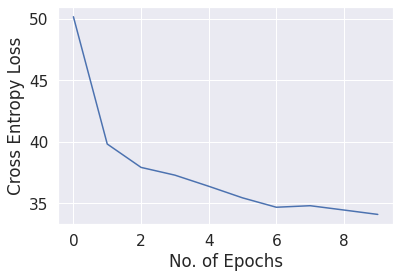

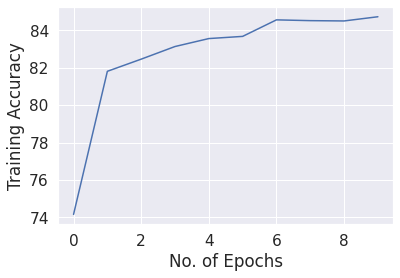

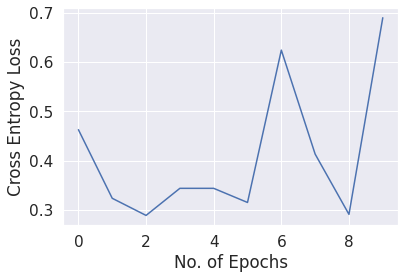

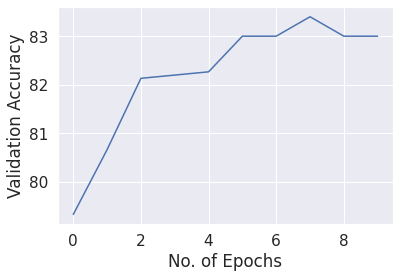

Finished Training


In [46]:
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet.to(device)

resnet.train()
lossEpochs = []
accEpochs = []
lossValid = []
accValid = []
for epoch in range(Epochs):  # loop over the dataset multiple times
    correct = 0
    total = 0

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
 
        # Accuracy calculation
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data.item()))
    
    acc = 100 * correct / total
    print('Training Accuracy of Epoch ' + str(epoch) + ': %d %%' % (acc))
    lossEpochs.append(running_loss)
    accEpochs.append(acc)

    # Validation Accuracy and Loss
    correct = 0
    total = 0
    valid_loss = 0.0
    confusionMatrix = np.zeros((2, 2));
    with torch.no_grad():
        for valid_data in validloader:
            images, labels = valid_data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            valid_loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print('Validation Accuracy of Epoch ' + str(epoch) + ': %d %%' % (acc))
    lossValid.append(valid_loss)
    accValid.append(acc)

    torch.save(resnet.state_dict(), 'resnet_lr_0001_ft.pth')

plt.plot(lossEpochs)
plt.xlabel("No. of Epochs")
plt.ylabel("Cross Entropy Loss")
plt.show()

plt.plot(accEpochs)
plt.xlabel("No. of Epochs")
plt.ylabel("Training Accuracy")
plt.show()

plt.plot(lossValid)
plt.xlabel("No. of Epochs")
plt.ylabel("Cross Entropy Loss")
plt.show()

plt.plot(accValid)
plt.xlabel("No. of Epochs")
plt.ylabel("Validation Accuracy")
plt.show()

print('Finished Training')

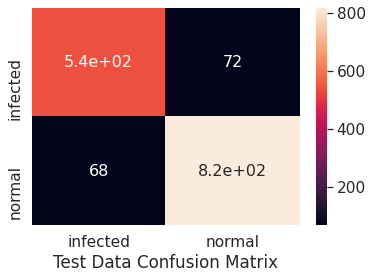

Accuracy of the network on Test Data: 90 %


In [52]:
correct = 0
total = 0
confusionMatrix = np.zeros((2, 2));
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        confusionMatrix += confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

acc = 100 * correct / total

df_cm = pd.DataFrame(confusionMatrix, class_names, class_names)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.xlabel("Test Data Confusion Matrix")
plt.show()

print('Accuracy of the network on Test Data: %d %%' % (acc))

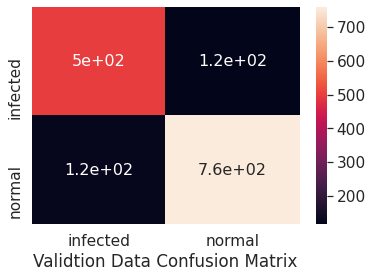

Accuracy of the network on Validation Data: 84 %


In [56]:
correct = 0
total = 0
confusionMatrix = np.zeros((2, 2));
with torch.no_grad():
    for data in validloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        confusionMatrix += confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

acc = 100 * correct / total

df_cm = pd.DataFrame(confusionMatrix, class_names, class_names)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.xlabel("Validtion Data Confusion Matrix")
plt.show()

print('Accuracy of the network on Validation Data: %d %%' % (acc))

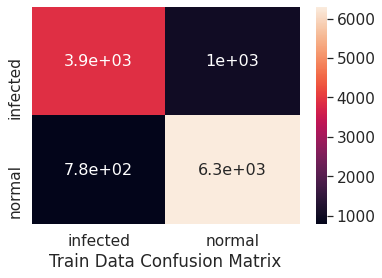

Accuracy of the network on Train Data: 84 %


In [57]:
correct = 0
total = 0
confusionMatrix = np.zeros((2, 2));
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        confusionMatrix += confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())

acc = 100 * correct / total

df_cm = pd.DataFrame(confusionMatrix, class_names, class_names)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.xlabel("Train Data Confusion Matrix")
plt.show()

print('Accuracy of the network on Train Data: %d %%' % (acc))